In [1]:
import numpy as np
import pandas as pd
import finance_toolkit as fin

%load_ext autoreload
%autoreload 2



# Portifolio

## Market cap index

In [ ]:
ind_nfirms = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
ind_nfirms.index = pd.to_datetime(ind_nfirms.index, format="%Y%m").to_period('M')


In [ ]:
ind_nfirms.head()

In [ ]:
ind_nfirms.columns

In [ ]:
ind_nfirms.columns = ind_nfirms.columns.str.strip()

In [ ]:
ind_nfirms.head()

In [ ]:
ind_size = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
ind_size.index = pd.to_datetime(ind_size.index, format="%Y%m").to_period('M')
ind_size.columns = ind_size.columns.str.strip()

In [ ]:
ind_size.head()

In [ ]:
ind_returns = pd.read_csv(f"data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
ind_returns.index = pd.to_datetime(ind_returns.index, format="%Y%m").to_period('M')
ind_returns.columns = ind_returns.columns.str.strip()

In [ ]:
ind_returns.head()

In [ ]:
print(ind_nfirms.shape)
print(ind_size.shape)
print(ind_returns.shape)

In [ ]:
ind_mktcap = ind_nfirms * ind_size

In [ ]:
ind_mktcap.shape

In [ ]:
total_mktcap = ind_mktcap.sum(axis='columns')

In [ ]:
total_mktcap.plot()

In [ ]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

In [ ]:
all(abs(ind_capweight.sum(axis="columns") - 1) < 1E-10)

In [ ]:
ind_capweight[["Steel", "Fin"]].plot()

In [ ]:
total_market_return = (ind_capweight * ind_returns).sum(axis="columns")
total_market_index = (total_market_return + 1).cumprod()
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018")

In [ ]:
total_market_index["1980":].plot(figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot()

In [ ]:
total_market_return.rolling(window=36).aggregate(fin.annualize_return, periods_per_year=12)

In [ ]:
tmi_36rets = total_market_return.rolling(window=36).aggregate(fin.annualize_return, periods_per_year=12)
tmi_36rets.plot(figsize=(12,5), label="36 mo Returns", legend=True)
total_market_return.plot(label="Returns", legend=True)

In [ ]:
ts_corr = ind_returns.rolling(window=36).corr()

In [ ]:
ts_corr.tail()

In [ ]:
ts_corr.index.names = ['date', 'industry']
ts_corr.tail()

In [ ]:
ind_36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

In [ ]:
tmi_36rets.plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_36corr.plot(legend=True, label="Tr 36 mo Avg Correlation")

In [ ]:
tmi_36rets.corr(ind_36corr)

## backtest

In [2]:
ind49_mcap = pd.read_csv("data/ind49_mcap.csv", header=0, index_col=0)
ind49_rets = pd.read_csv("data/ind49_rets.csv", header=0, index_col=0)

In [3]:
def weight_ew(r, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[0]]

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [5]:
def randw(r, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    rr = np.random.rand(r.shape[1])
    rr = rr/rr.sum()
    return pd.Series(rr, index=r.columns)


In [6]:
r = fin.annualize_return(ind49_rets)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.756726,6.631369,0.071402,0.102331,0.568799,-0.528292
CW,0.120165,0.147544,-0.715722,5.539543,0.065632,0.093769,0.594625,-0.515999
rW,0.122219,0.161536,-0.742128,6.857635,0.071579,0.102987,0.555458,-0.541252


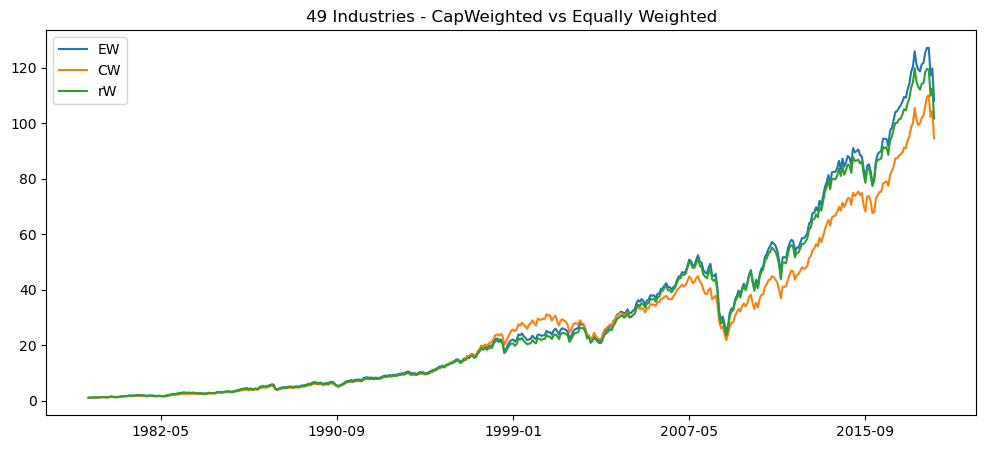

In [7]:
ewr = backtest_ws(ind49_rets)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
rwr = backtest_ws(ind49_rets, weighting=randw
                 )

btr = pd.DataFrame({"EW": ewr, "CW": cwr, "rW": rwr})
(1+btr).cumprod().plot(figsize=(12,5), title="49 Industries - CapWeighted vs Equally Weighted")
fin.summary_stats(btr.dropna())

## Fronteira eficiente

In [8]:
ind = ind49_rets

In [9]:
fin.var_gaussian(ind[["Food", "Beer", "Smoke"]], modified=True)

Food     0.058184
Beer     0.073325
Smoke    0.088623
dtype: float64

<Axes: >

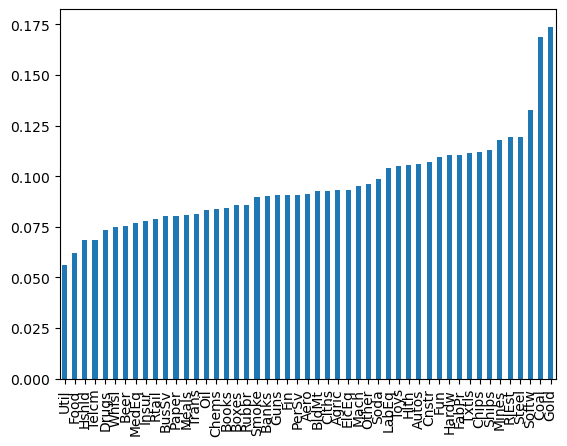

In [10]:
fin.var_gaussian(ind).sort_values().plot.bar()

In [ ]:
fin.sharpe_ratio(ind, 0.03, 12).sort_values()

In [ ]:
fin.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2018")

In [ ]:
fin.sharpe_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title='Industry Sharpe Ratios since 2000')

In [11]:
er = fin.annualize_return(ind["1996":"2000"], 12)

<Axes: >

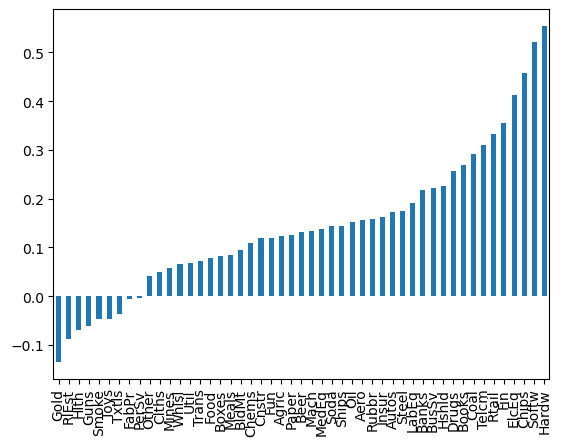

In [12]:
er.sort_values().plot.bar()

In [13]:
cov = ind["1996":"2000"].cov()
cov.shape

(49, 49)

In [14]:
cov

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Agric,0.005044,0.000575,0.001179,0.000700,0.000369,0.001360,0.000341,0.000927,0.000977,0.001453,...,0.001458,0.001029,0.000587,0.000979,0.000781,0.001122,0.000994,0.001423,0.001846,0.001014
Food,0.000575,0.002072,0.003134,0.002106,0.001392,0.001108,0.001065,0.001101,0.001455,0.001217,...,0.001495,0.001377,0.000926,0.001033,0.000912,0.002097,0.001761,0.000909,0.001670,0.001471
Soda,0.001179,0.003134,0.010853,0.005118,0.002425,0.003288,0.001981,0.002496,0.003783,0.003411,...,0.004180,0.003608,0.002463,0.002697,0.002159,0.004670,0.003788,0.002759,0.004609,0.003859
Beer,0.000700,0.002106,0.005118,0.005340,0.001340,0.002328,0.002065,0.001507,0.003064,0.001975,...,0.002666,0.002504,0.001355,0.002005,0.001964,0.003341,0.002922,0.001625,0.003642,0.002494
Smoke,0.000369,0.001392,0.002425,0.001340,0.007013,0.001156,0.000376,-0.000200,0.000710,0.000112,...,0.001393,0.000142,0.001736,0.000279,0.000416,0.000971,0.000712,0.000735,0.000568,0.001161
Toys,0.001360,0.001108,0.003288,0.002328,0.001156,0.004821,0.002334,0.000842,0.001829,0.002047,...,0.002366,0.001872,0.001565,0.001555,0.001887,0.001916,0.001595,0.001899,0.002910,0.002134
Fun,0.000341,0.001065,0.001981,0.002065,0.000376,0.002334,0.004168,0.001635,0.001702,0.002234,...,0.002145,0.001828,0.002005,0.002126,0.001781,0.002426,0.001899,0.002050,0.003369,0.002838
Books,0.000927,0.001101,0.002496,0.001507,-0.000200,0.000842,0.001635,0.002406,0.001566,0.002017,...,0.001751,0.001881,0.001218,0.002002,0.001002,0.002088,0.001862,0.001681,0.002557,0.002521
Hshld,0.000977,0.001455,0.003783,0.003064,0.000710,0.001829,0.001702,0.001566,0.002826,0.001735,...,0.002395,0.001947,0.001184,0.001761,0.001412,0.002542,0.002256,0.001211,0.003020,0.002053
Clths,0.001453,0.001217,0.003411,0.001975,0.000112,0.002047,0.002234,0.002017,0.001735,0.004314,...,0.002776,0.002245,0.001977,0.002524,0.001820,0.002649,0.001881,0.002592,0.003204,0.003673


In [15]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [16]:
l = ["Food", "Beer", "Smoke", "Coal"]

In [17]:
er[l]

Food     0.078174
Beer     0.131785
Smoke   -0.046691
Coal     0.291039
dtype: float64

In [18]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002072,0.002106,0.001392,0.000712
Beer,0.002106,0.005340,0.001340,0.003250
Smoke,0.001392,0.001340,0.007013,-0.001550
Coal,0.000712,0.003250,-0.001550,0.013730


In [19]:
ew = np.repeat(0.25, 4)
portfolio_return(ew, er[l])

0.11357670051386448

In [20]:
portfolio_vol(ew, cov.loc[l,l])

0.051633263850866265

### 2 ativos

In [21]:
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]

In [22]:
type(weights)

list

In [23]:
len(weights)

20

In [24]:
weights[4]

array([0.21052632, 0.78947368])

In [25]:
weights[-1]

array([1., 0.])

<Axes: xlabel='Vol', ylabel='Ret'>

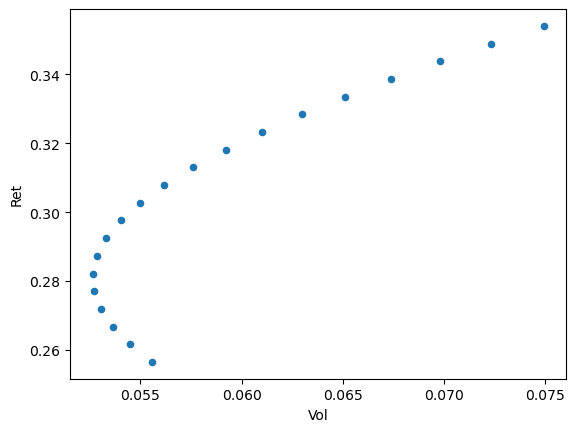

In [27]:
l = ["Drugs", "Fin"]
rets = [portfolio_return(w, er[l]) for w in weights]
vols = [portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({"Ret": rets, "Vol": vols})
ef.plot.scatter(x="Vol", y="Ret")

In [28]:
def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")


<Axes: xlabel='Volatility'>

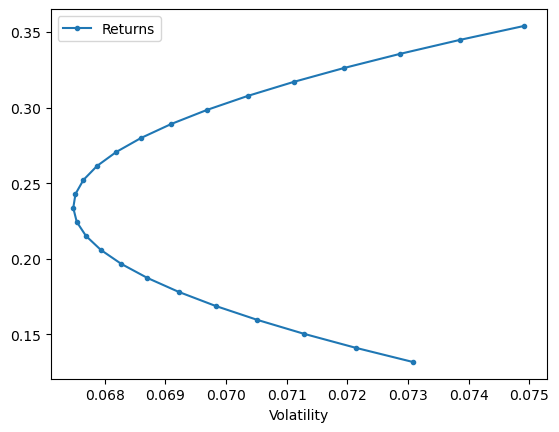

In [29]:
l = ["Fin", "Beer"]
plot_ef2(25, er[l].values, cov.loc[l,l])